# Plotting composite (stacked) spectra for the DESI DR1 paper
Stéphanie Juneau (NSF NOIRLab), on behalf of the DESI Collaboration and the Astro Data Lab and SPARCL teams

This notebook was used to produce Figure 7 from the DESI DR1 manuscript, which shows composite spectra for the extragalactic target classes:
- BGS: Bright Galaxy Survey
- LRG: Luminous Red Galaxies
- ELG: Emission-Line Galaxies
- QSO: Quasi-Stellar Objects (Quasars)
- Lya-QSO: Lyman-alpha QSO (QSO target class at redshift z>2.1)

It uses the [Astro Data Lab](https://datalab.noirlab.edu/) to query example objects in very thin slices of redshift then uses SPectra Analysis and Retrievable Catalog Lab ([SPARCL](https://astrosparcl.datalab.noirlab.edu/)) to retrieve the spectra. This notebook also requires some of the DESI software (namely the `desitarget` package) and was run using the `DESI 23.1` kernel at the Astro Data Lab (also available at NERSC).

If you use or modify this notebook for your work, make sure to include acknowledgments for:
- DESI data: https://data.desi.lbl.gov/doc/acknowledgments/
- Astro Data Lab: https://datalab.noirlab.edu/acknowledgments.php
- SPARCL: https://astrosparcl.datalab.noirlab.edu/sparc/acknowledgments/

### If necessary, install the datalab and sparcl clients

If you are using the Astro Data Lab Jupyter notebook server, you do not need to run these cell because they are already installed.

#### NOTE: After installing the most recent version, please restart your kernel.

In [1]:
## Uncomment the following only if the Astro Data Lab client is not already installed
#!pip install --upgrade astro-datalab

In [2]:
## Uncomment the following only if SPARCL client is not already installed
#!pip install --upgrade sparclclient

### Disclaimers
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

## Imports

In [3]:
# import some helpful python packages 
import numpy as np
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.pyplot as plt
import pandas as pd

# will no longer need for public version
from getpass import getpass

# DESI targeting masks
from desitarget import targetmask    # for Main survey (different for sv1, sv2, sv3)

## DataLab and SPARCL related modules
from sparcl.client import SparclClient
from dl import queryClient as qc

# plots default setup
plt.rcParams['font.size'] = 14
# Axes width
width = {'linewidth':1.5}
plt.rc('axes', **width)
# x- and y- ticks
ticks = {'major.size':5.0, 'minor.size':3.0, 'major.width':1.5, 'minor.width':1., 'direction':'in',\
        'minor.visible':True}
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

In [4]:
## Load SPARCLClient
client = SparclClient()

## Function to plot location of spectral lines

In [7]:
def add_lines(z, ax=None, rest_frame=True, em_label=True, \
              abs_label=True, em_lines=None, abs_lines=None, \
              xr=None, label_offset=120):
    """
    Function to add emission and/or absorption lines onto a plot. 
    
    If em_lines or abs_lines is given, plotting only the specified lines.
    If no lines are given, plotting all the lines that are present in x-range of the plot.
    
    Parameters
    ----------
    z : float
        Redshift value of the source
    
    ax : AxesSubplot
        The axis onto which the emission/absoption lines needs to be plotted.
        If ax = None, then the plotting function uses plt, rather than axis.
        
    rest_frame : bool
        Whether or not the plot is in rest-frame. Default is True.
    
    em_label : bool
        Whether or not to label the emission lines. Default is True.
        
    abs_label : bool
        Whether or not to label the absorption lines. Default is True.
    
    em_lines : list
        List of emission lines to label
    
    abs_lines : list
        List of absorption lines to label
    
    Returns
    -------
    None
    
    """
    
    # List of lines
    # This is a subset of emission lines from the spZline files. 
    # All the wavelengths are in vaccuum wavelengths.

    # Emission Lines (selected subset; NOT A COMPLETE LIST)
    emission_lines = [
    {"name" : "Ly-beta",        "lambda" : 1025.72,  "emission": True,  "label" : " Ly$\\beta$"},
    {"name" : "O VI",           "lambda" : 1031.91,  "emission": True,  "label" : "  " }, # O VI
    {"name" : "O VI",           "lambda" : 1037.61,  "emission": True,  "label" : "  " }, # O VI
    {"name" : "Ly-alpha",       "lambda" : 1215.67,  "emission": True,  "label" : "  Ly$\\alpha$"},
    {"name" : "N V 1240",       "lambda" : 1240.81,  "emission": True,  "label" : ""}, # " N V"
    {"name" : "C IV 1549",      "lambda" : 1549.48,  "emission": True,  "label" : "  C IV" },
    {"name" : "C III] 1908",    "lambda" : 1908.734, "emission": True,  "label" : " C III]"},
    {"name" : "Mg II 2796",     "lambda" : 2796.,    "emission": True,  "label" : " Mg II" },
    {"name" : "Mg II 2803",     "lambda" : 2803.,    "emission": True,  "label" : " " },
    {"name" : "[O II] 3725",    "lambda" : 3727.092, "emission": True,  "label" : " "},
    {"name" : "[O II] 3727",    "lambda" : 3729.875, "emission": True,  "label" : " [O II]"}, 
    {"name" : "[Ne III] 3868",  "lambda" : 3869.857, "emission": True,  "label" : "[Ne III]"},
    {"name" : "[Ne III] 3970",  "lambda" : 3971.123, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": True,  "label" : " H$\\delta$"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": True,  "label" : " H$\\gamma$"},
    {"name" : "He II 4685",     "lambda" : 4686.991, "emission": True,  "label" : " He II"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": True,  "label" : " H$\\beta$"},
    {"name" : "[O III] 4959",   "lambda" : 4960.294, "emission": True,  "label" : "[O III]" },
    {"name" : "[O III] 5007",   "lambda" : 5008.239, "emission": True,  "label" : "[O III]" },
    {"name" : "He II 5411",     "lambda" : 5413.025, "emission": True,  "label" : " He II"},
    {"name" : "[O I] 5577",     "lambda" : 5578.888, "emission": True,  "label" : " [O I]" },
    {"name" : "[N II] 5755",    "lambda" : 5756.186, "emission": True,  "label" : "[Ne II]" },
    {"name" : "He I 5876",      "lambda" : 5877.308, "emission": True,  "label" : " He I" },
    {"name" : "[O I] 6300",     "lambda" : 6302.046, "emission": True,  "label" : " [O I]" },
    {"name" : "[S III] 6312",   "lambda" : 6313.806, "emission": True,  "label" : "[S III]" },
    {"name" : "[O I] 6363",     "lambda" : 6365.535, "emission": True,  "label" : " [O I]" },
    {"name" : "[N II] 6548",    "lambda" : 6549.859, "emission": True,  "label" : " [N II]" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": True,  "label" : " H$\\alpha$" },
    {"name" : "[N II] 6583",    "lambda" : 6585.268, "emission": True,  "label" : " [N II]" },
    {"name" : "[S II] 6716",    "lambda" : 6718.294, "emission": True,  "label" : " [S II]" },
    {"name" : "[S II] 6730",    "lambda" : 6732.678, "emission": True,  "label" : " [S II]" },
    {"name" : "[Ar III] 7135",  "lambda" : 7137.758, "emission": True,  "label" : "[Ar III]" },]


    # Absorption lines (selected subset; NOT A COMPLETE LIST)
    absorption_lines = [
    {"name" : "Mg II 2796",     "lambda" : 2796., "emission": True,  "label" : " Mg II" },
    {"name" : "Mg II 2803",     "lambda" : 2803., "emission": True,  "label" : " " },
    {"name" : "K (Ca II 3933)", "lambda" : 3934.814, "emission": False, "label" : " H+K"},
    {"name" : "H (Ca II 3968)", "lambda" : 3969.623, "emission": False, "label" : " "},
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": False, "label" : " H$\\delta$" },
    {"name" : "G (Ca I 4307)",  "lambda" : 4308.952, "emission": False, "label" : " G"}, # G (Ca I)
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": False, "label" : " H$\\beta$"},
    {"name" : "Mg I 5183",      "lambda" : 5185.048, "emission": False, "label" : " "},
    {"name" : "Mg I 5172",      "lambda" : 5174.125, "emission": False, "label" : " "},
    {"name" : "Mg I 5167",      "lambda" : 5168.762, "emission": False, "label" : " Mg I"},
    {"name" : "D2 (Na I 5889)", "lambda" : 5891.582, "emission": False, "label" : " " },
    {"name" : "D1 (Na I 5895)", "lambda" : 5897.554, "emission": False, "label" : " Na D" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": False, "label" : " H$\\alpha$"},
    ]
    
    if (ax == None):
        # If there is no axes given, plotting with the plt function
        ax = plt.gca()
    
    if (em_lines != None):
        # Choosing the emission lines listed by the user
        emission_lines = list(filter(lambda x: x['name'] in em_lines, emission_lines))
    
    if (abs_lines != None):
        # Choosing the absorption lines listed by the user
        absorption_lines = list(filter(lambda x: x['name'] in abs_lines, absorption_lines)) 

    if xr!=None:
        xbounds = xr
    else:
        xbounds = ax.get_xbound()   # Getting the x-range of the plot 
    # This is for selecting only those lines that are visible in the x-range of the plot
    
    for ii in range(len(emission_lines)):
        # If rest_frame = False, redshifting the emission lines to the observed frame of the source
        if (rest_frame == False):
            lam = emission_lines[ii]['lambda']*(1+z)
        else:
            lam = emission_lines[ii]['lambda']
        # Plotting the emission lines if they are within the x-range of the plot
        if (emission_lines[ii]['emission']) & (lam > xbounds[0]) & (lam < xbounds[1]):
            ax.axvline(lam, 0.9, 1.0, color = 'grey', lw=1.0, alpha=0.7)
            ax.axvline(lam, color='grey', lw=1.0, linestyle=':', alpha=0.7)

            trans = ax.get_xaxis_transform()
            if (em_label == True):
                # Labeling the emission lines if em_label = True
                ax.annotate(emission_lines[ii]['label'], xy=(lam-label_offset, 0.72), xycoords=trans, \
                         fontsize=12, rotation=90, color='grey')
            
    for ii in range(len(absorption_lines)):
        # If rest_frame = False, redshifting the absorption lines to the observed frame of the source
        if (rest_frame == False):
            lam = absorption_lines[ii]['lambda']*(1+z)
        else:
            lam = absorption_lines[ii]['lambda']
        # Plotting the absorption lines if they are within the x-range of the plot
        if (lam > xbounds[0]) & (lam < xbounds[1]):
            col_abs = 'rosybrown' #'indianred'
            ax.axvline(lam, 0., 1., color=col_abs, lw=1.0, linestyle=':', alpha=0.5)
            ax.axvline(lam, 0.05, 0.15, color=col_abs, lw=1.0, alpha=0.7)
            trans = ax.get_xaxis_transform()
            if (abs_label == True):
                # Labeling the absorption lines if abs_label = True
                ax.annotate(absorption_lines[ii]['label'], xy=(lam-label_offset, 0.72), xycoords=trans, \
                         fontsize=12, rotation=90, color=col_abs)

## Function to query per target type

In [8]:
def query_targets(targetclass='BGS_ANY', limit=10000, zmin=None, zmax=None):
# targetclass: valid target class for the DESI_TARGET bitmask (e.g., BGS_ANY, LRG, ELG, QSO)
# zmin, zmax: if defined, constraints on min/max redshift z
# Returns the SQL query to send as input to queryClient

    # Targeting mask to decode DESI_TARGET column
    target_mask = targetmask.desi_mask[targetclass].mask
    target_col = 'desi_target'

    zmin_clause = ''
    zmax_clause = ''
    if zmin!=None:
        zmin_clause = f' AND (z>={zmin})'
    if zmax!=None:
        zmax_clause = f' AND (z<={zmax})'

    # Query on the datalab database desi_dr1
    q = f"""SELECT zp.targetid, zp.survey, zp.program,  
                   zp.z, zp.zwarn, zp.spectype, zp.desi_target
            FROM desi_dr1.zpix AS zp
            WHERE (survey='main' AND main_primary AND {target_col}&({target_mask})!=0{zmin_clause}{zmax_clause})
            LIMIT {limit}
            """ 

    return(q)

## Information about the query
##
## Selected columns:
##  targetid, survey, program -- unique identifiers for a given spectrum
##  z -- spectroscopic redshift of the target
##  zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
##  spectype -- Spectral type of the target: STAR | GALAXY | QSO
##  desi_target -- encodeds main survey's desi targeting information
##
## Constraints (WHERE statement):
##  survey = 'main' to consider only the Main survey
##  main_primary -- keep if a given coadded spectrum is the primary spectrum in the Main survey (MAIN_PRIMARY=True)
##  "{target_col}&({target_mask})!=0" -- selection on the target type
##  zmin_clause -- minimum redshift cut
##  zmax_clause -- maximum redshift cut

In [9]:
def get_spec(tids, survey='main', spectype='GALAXY'):
# Function taking list of TARGETIDs as input and returning a dataFrame with the spectra as output
    
    # Define the fields to include in the retrieve function
    inc = ['specid', 'redshift', 'survey', 'program', 'redshift_warning', 
           'flux', 'wavelength', 'model', 'ivar', 'mask', 'spectype', 'main_primary']

    # Convert the targetid's to a list of integers (SPARCL requirement)
    specids = tids.astype(int).tolist()

    # Call SPARCL client to retrieve the spectra from DESI-DR1
    results = client.retrieve_by_specid(specid_list=specids, include=inc, dataset_list=['DESI-DR1'])

    # Convert the output into a Pandas DataFrame
    df_desi = pd.json_normalize(results.records)

    # Important to remove extra entries for the same TARGETID but from possibly other surveys/programs
    keep = (df_desi['redshift_warning']==0)&(df_desi['spectype']==spectype)&(df_desi['survey']==survey)&(df_desi['main_primary']==1)

    return(df_desi[keep])

In [10]:
def get_stack(tclass, zmed, spectype='GALAXY', Nmax=100):

    # Set redshift tolerance based on GALAXY or QSO spectral type
    if spectype=='GALAXY':
        dz = 0.00001*(1.+zmed)
    if spectype=='QSO':
        dz = 0.00003*(1.+zmed)

    # Obtain and execute query
    q_target = query_targets(targetclass=tclass, limit=1000, zmin=zmed-dz, zmax=zmed+dz)
    t = qc.query(sql=q_target, fmt='table')

    # clean on SPECTYPE and ZWARN
    t = t[(t['spectype']==spectype)&(t['zwarn']==0)]   
    
    # Keep unique TARGETIDs
    tid_uniq, idx_uniq = np.unique(t['targetid'], return_index=True)
    t = t[idx_uniq]
    
    # Nb of results
    Nres = len(t)
    print('Found N= ',Nres)

    Nstack = np.min([Nmax,Nres])
    print('Will stack up to Nmax=',Nmax,' --> here we will get ',Nstack)

    # Get unique IDs
    tids_for_stack = t['targetid'][:Nstack]
    
    df_target = get_spec(tids_for_stack, spectype=spectype)
    
    # check there are no duplicates
    assert len(df_target)==len(np.unique(df_target['specid'])), "Check for duplicates"

    return(df_target)

## Define target redshift

In [11]:
# Bright time choice of representative redshift
zmed_bgs = 0.2

# Dark time choice of representative redshifts
zmed_lrg = 0.7
zmed_elg = 1.2
zmed_qso = 1.5
zmed_lya = 2.65

## Create stacked spectra of extragalactic targets (per target class)

In [12]:
# BGS
df_stack_bgs = get_stack('BGS_ANY',zmed_bgs)

Found N=  494
Will stack up to Nmax= 100  --> here we will get  100


In [13]:
# LRG
df_stack_lrg = get_stack('LRG',zmed_lrg)

Found N=  151
Will stack up to Nmax= 100  --> here we will get  100


In [14]:
# ELG
df_stack_elg = get_stack('ELG',zmed_elg)

Found N=  186
Will stack up to Nmax= 100  --> here we will get  100


In [15]:
# QSO
df_stack_qso = get_stack('QSO', zmed_qso, spectype='QSO')

Found N=  118
Will stack up to Nmax= 100  --> here we will get  100


In [16]:
# Lya-QSO (QSO targets but at z>2.1)
df_stack_lya = get_stack('QSO', zmed_lya, spectype='QSO')

Found N=  75
Will stack up to Nmax= 100  --> here we will get  75


## Plot stacked spectra of extragalactic targets (BGS, LRG, ELG, QSO, Lya-QSO)

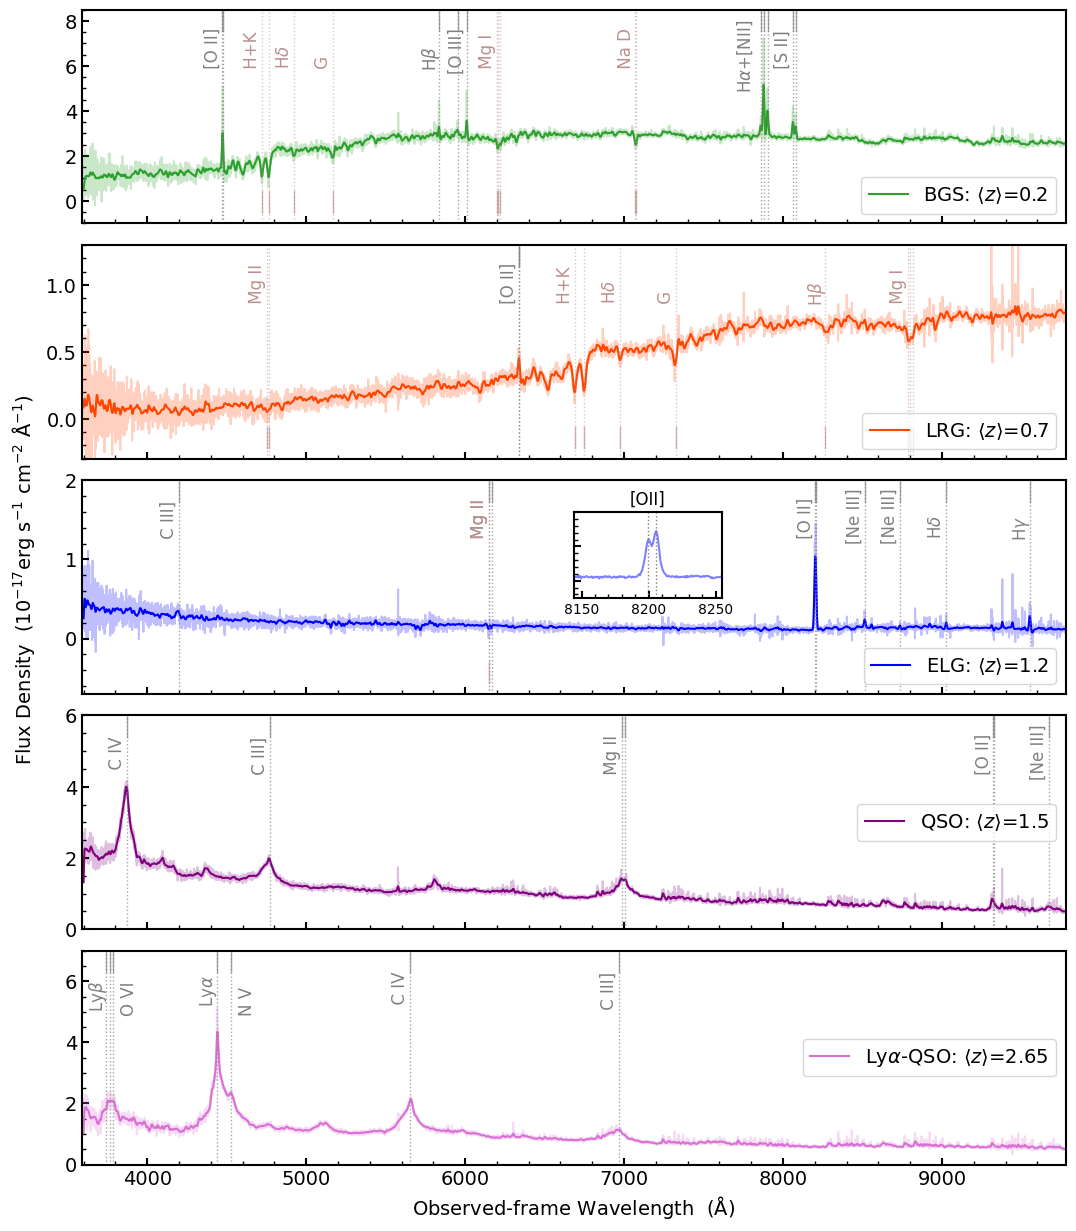

In [17]:
## Extragalactic targets
fig, axs = plt.subplots(5, 1, figsize=(12,15), sharex=True) #, tight_layout=True)
fig.subplots_adjust(hspace=0.1, left=0.08)

specs = [df_stack_bgs, df_stack_lrg, df_stack_elg, df_stack_qso, df_stack_lya]
cols = ['tab:green','orangered','blue','purple','orchid']
ylims = [[-1,8.5],[-0.3,1.3], [-0.7,2], [0,6], [0,7]]
names = ['BGS', 'LRG', 'ELG', 'QSO', 'Ly$\\alpha$-QSO']
locs = ['lower right', 'lower right', 'lower right', 'center right', 'center right']

xr = [3590,9780]

for i, sp in enumerate(specs):
    z = sp['redshift'].iloc[0]
    wl = sp['wavelength'].iloc[0]

    # Remove duplicate IDs
    tid_uniq, idx_uniq = np.unique(sp['specid'], return_index=True)
    Nuniq = len(tid_uniq)
    
    # Stacked flux (problem with using median with this format?)
    flam = np.average(np.array(sp['flux'].iloc[idx_uniq]), axis=0, weights=sp['ivar'].iloc[idx_uniq])    

    col = cols[i]
    ax = axs.flat[i]

    # Plot per panel
    ax.plot(wl, flam, color=col, alpha=0.25)
    label = f"{names[i]}: $\\langle z\\rangle$={np.round(z,2)}"
    ax.plot(wl, convolve(flam, Gaussian1DKernel(5)), color=col, label=label)
    ax.set_ylim(ylims[i])
    ax.legend(loc=locs[i])

    ## Add absorption+emission lines for BGS
    if names[i]=='BGS':
        emlines = ["[O II] 3725","[O II] 3727","H-beta","[O III] 5007","[S II] 6716"]
        abslines = ["K (Ca II 3933)","H (Ca II 3968)","H-delta","G (Ca I 4307)",\
                    "Mg I 5183","Mg I 5172","Mg I 5167","D2 (Na I 5889)","D1 (Na I 5895)"]
        add_lines(z, ax=ax, rest_frame=False, em_label=True, abs_label=True, em_lines=emlines, abs_lines=abslines, xr=xr)
        # add lines manually that were too crowded
        for lam in [4960.294, 6549.859, 6564.614, 6585.268, 6732.678]:
            ax.axvline(lam*(1.+z), 0.9, 1.0, color = 'grey', lw=1.0, alpha=0.7)
            ax.axvline(lam*(1.+z), color='grey', lw=1.0, linestyle=':', alpha=0.7)
        ax.annotate("H$\\alpha$+[NII]", xy=(7700, 5), fontsize=12, rotation=90, color='grey')

    ## Add absorption lines for LRG
    if names[i]=='LRG':
        add_lines(z, ax=ax, rest_frame=False, em_label=True, abs_label=True, em_lines=["[O II] 3725","[O II] 3727"], abs_lines=None, xr=xr)

    ## Add emission lines for QSOs
    if (names[i]=='QSO')|(names[i]=='Ly$\\alpha$-QSO'):
        add_lines(z, ax=ax, rest_frame=False, em_label=True, abs_label=False, em_lines=None, abs_lines=[''], xr=xr)

        if names[i]=='Ly$\\alpha$-QSO':
            # Add manually labels that were too crowded
            ax.annotate("O VI", xy=(3830, 5), fontsize=12, rotation=90, color='grey')
            ax.annotate("N V", xy=(4570, 5), fontsize=12, rotation=90, color='grey')
     
    ## Add inset for ELG
    if names[i]=='ELG':
        axin1 = ax.inset_axes([0.5, 0.45, 0.15, 0.4])
        axin1.set_facecolor('w')
        axin1.plot(wl, flam, color=col, alpha=0.5)
        axin1.set_xlim(3702*(1+z),3752*(1+z))
        axin1.set_ylim(-0.5,2)
        axin1.axvline(3727.092*(1+z),ls=':',color='grey',lw=1)
        axin1.axvline(3729.875*(1+z),ls=':',color='grey',lw=1)
        axin1.set_title('[OII]', fontsize=12)
        axin1.tick_params(labelleft=False, labelsize=10)

        add_lines(z, ax=ax, rest_frame=False, em_label=True, abs_label=True, em_lines=None, abs_lines=['Mg II 2796'], xr=xr)

plt.xlim(xr)
plt.xlabel('Observed-frame Wavelength  ($\mathrm{\\AA}$)')
fig.supylabel('Flux Density  ($\mathrm{10^{-17} erg\ s^{-1}\ cm^{-2}\ \\AA^{-1}}$)', fontsize=14)
plt.show()

In [18]:
# Output figure file
outfile = "DR1-spectra.png"
fig.savefig(outfile, bbox_inches='tight', dpi=150)

Acknowledgments
---------------

If you use any **DESI data**, refer to the official [DESI Acknowledgments and Data Licence page](https://data.desi.lbl.gov/doc/acknowledgments/).

If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL (Juneau et al. 2024)}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.